In [ ]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from os.path import exists
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When

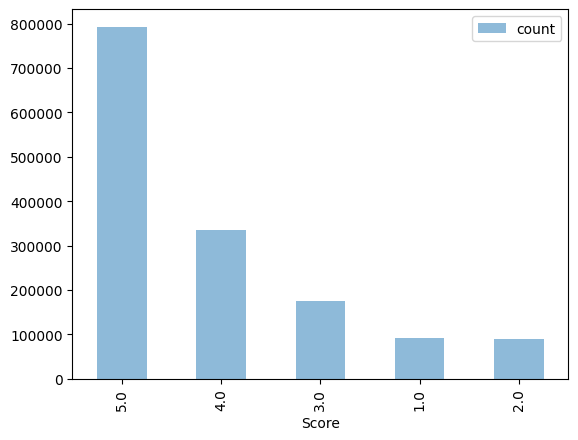

EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [ ]:
# Mount Google Drive for saving pickle files
from google.colab import drive
drive.mount('/content/drive')

# Load training and testing datasets
train_path = '/content/drive/My Drive/BU/Fall 2024/CS506/Midterm/data/train.csv'
test_path = '/content/drive/My Drive/BU/Fall 2024/CS506/Midterm/data/test.csv'

# Load data
trainingSet = pd.read_csv(train_path)
testingSet = pd.read_csv(test_path)

# Display initial data information
print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)
print()
print(trainingSet.head())
print()
print(testingSet.head())
print()
print(trainingSet.describe())

# Plot 'Score' column value counts
if 'Score' in trainingSet.columns:
    trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
    plt.show()

print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Set pickle path and helper functions for saving/loading pickle files
PICKLE_PATH = '/content/drive/My Drive/BU/Fall 2024/CS506/Midterm/data/'
os.makedirs(PICKLE_PATH, exist_ok=True)

def save_pickle(obj, filename):
    with open(os.path.join(PICKLE_PATH, filename), 'wb') as f:
        pickle.dump(obj, f)

def load_pickle(filename):
    with open(os.path.join(PICKLE_PATH, filename), 'rb') as f:
        return pickle.load(f)

In [ ]:
# Feature Engineering
def add_features_to(df):
    # Calculate helpfulness ratio
    if 'HelpfulnessNumerator' in df.columns and 'HelpfulnessDenominator' in df.columns:
        df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
        df['Helpfulness'] = df['Helpfulness'].fillna(0)
    # Add text length feature
    if 'Text' in df.columns:
        df['Text_length'] = df['Text'].apply(lambda x: len(str(x).split()))
    return df

# Apply feature engineering and save results if not already processed
if exists(os.path.join(PICKLE_PATH, 'X_train.pkl')) and exists(os.path.join(PICKLE_PATH, 'X_submission.pkl')):
    print("Loading preprocessed datasets from pickle files...")
    X_train = load_pickle('X_train.pkl')
    X_submission = load_pickle('X_submission.pkl')
else:
    train = add_features_to(trainingSet)
    test = add_features_to(testingSet)

    X_submission = pd.merge(train, test, on='Id', how='right').drop(columns=['Score_x'], errors='ignore').rename(columns={'Score_y': 'Score'})
    X_train = train[train['Score'].notnull()]

    # Downsample majority class to balance the dataset
    fives = X_train[X_train['Score'] == 5].sample(frac=0.5, random_state=0)
    X_train = pd.concat([X_train[X_train['Score'] != 5], fives])

    # Save processed data
    save_pickle(X_train, 'X_train.pkl')
    save_pickle(X_submission, 'X_submission.pkl')

print("Feature engineering completed!")

Loading preprocessed datasets from pickle files...
Feature engineering completed!


In [ ]:
# Split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X_train.drop(columns=['Score']), X_train['Score'], test_size=0.25, random_state=0)

In [ ]:
# Define Features
numeric_features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness']
categorical_features = ['ProductId', 'UserId']
text_features = ['Text', 'Summary']

# Preprocess numerical features
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train[numeric_features])
X_test_numeric = scaler.transform(X_test[numeric_features])
X_submission_numeric = scaler.transform(X_submission[numeric_features])

# One-Hot Encoding for categorical features
ohe = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_train_categorical = ohe.fit_transform(X_train[categorical_features])
X_test_categorical = ohe.transform(X_test[categorical_features])
X_submission_categorical = ohe.transform(X_submission[categorical_features])

# TF-IDF Vectorization for text features with dimensionality reduction
if exists(os.path.join(PICKLE_PATH, 'X_train_text_svd.pkl')) and exists(os.path.join(PICKLE_PATH, 'X_test_text_svd.pkl')):
    print("Loading precomputed TF-IDF and SVD transformed matrices...")
    X_train_text_svd = load_pickle('X_train_text_svd.pkl')
    X_test_text_svd = load_pickle('X_test_text_svd.pkl')
    X_submission_text_svd = load_pickle('X_submission_text_svd.pkl')
else:
    tfidf_text = TfidfVectorizer(max_features=5000, stop_words='english')
    X_train_text = tfidf_text.fit_transform(X_train['Text'].fillna(''))
    X_test_text = tfidf_text.transform(X_test['Text'].fillna(''))
    X_submission_text = tfidf_text.transform(X_submission['Text'].fillna(''))

    # Adjusted to 100 components for better dimensionality reduction
    svd = TruncatedSVD(n_components=100, random_state=42)
    X_train_text_svd = svd.fit_transform(X_train_text)
    X_test_text_svd = svd.transform(X_test_text)
    X_submission_text_svd = svd.transform(X_submission_text)

    # Save TF-IDF + SVD matrices
    save_pickle(X_train_text_svd, 'X_train_text_svd.pkl')
    save_pickle(X_test_text_svd, 'X_test_text_svd.pkl')
    save_pickle(X_submission_text_svd, 'X_submission_text_svd.pkl')

# Combine all features into final matrices
X_train_final = hstack([csr_matrix(X_train_numeric), X_train_categorical, csr_matrix(X_train_text_svd)])
X_test_final = hstack([csr_matrix(X_test_numeric), X_test_categorical, csr_matrix(X_test_text_svd)])
X_submission_final = hstack([csr_matrix(X_submission_numeric), X_submission_categorical, csr_matrix(X_submission_text_svd)])

# Save final matrices for reloading if necessary
save_pickle(X_train_final, 'X_train_final.pkl')
save_pickle(X_test_final, 'X_test_final.pkl')
save_pickle(X_submission_final, 'X_submission_final.pkl')

print("Feature preprocessing completed!")

Loading precomputed TF-IDF and SVD transformed matrices...
Feature preprocessing completed!


Logistic Regression - Accuracy on test set: 0.55700797237224


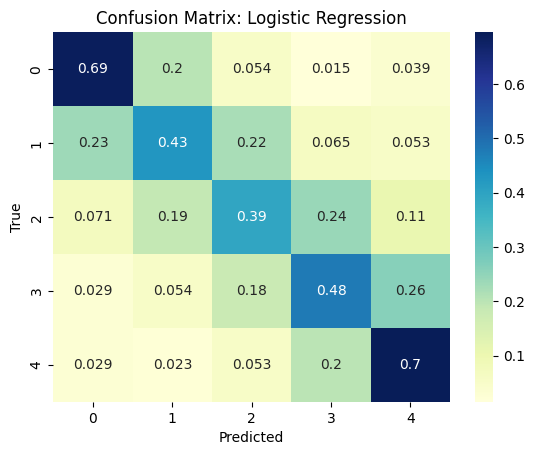

Submission file created.


In [ ]:
import gc

# Model Training and Evaluation Function
def evaluate_model(model, X_train, Y_train, X_test, Y_test, model_name):
    model.fit(X_train, Y_train)
    Y_test_predictions = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_test_predictions)
    print(f"{model_name} - Accuracy on test set: {accuracy}")
    cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
    sns.heatmap(cm, annot=True, cmap="YlGnBu")
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Free memory after evaluation
    del Y_test_predictions
    gc.collect()

    return model

# Instantiate Logistic Regression with fewer iterations
logistic_regression_model = LogisticRegression(
    max_iter=500,  # Reduced iterations for faster runtime
    random_state=42, # Saga is often faster for larger datasets
    C=0.1,          # Moderate regularization strength
    class_weight='balanced'  # Helps mitigate class imbalance
)

# Train and evaluate the model
evaluate_model(
    logistic_regression_model,
    X_train_final,
    Y_train,
    X_test_final,
    Y_test,
    "Logistic Regression"
)

# Uncomment to save model to pickle
save_pickle(logistic_regression_model, 'Logistic_Regression_model.pkl')

# Free memory after saving model
del logistic_regression_model
gc.collect()

# Submission with best model (replace 'Logistic Regression' with your best model)
best_model_name = "Logistic Regression"  # Select best model based on evaluation
best_model = load_pickle(f'{best_model_name.replace(" ", "_")}_model.pkl')
X_submission['Score'] = best_model.predict(X_submission_final)
submission = X_submission[['Id', 'Score']]

# Uncomment to save submission file
submission.to_csv("/content/drive/My Drive/BU/Fall 2024/CS506/Midterm/data/submission.csv", index=False)
print("Submission file created.")